In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimDataTypes as DataTypes
from Gurobi_Solution_ChargingStations import *
from Gurobi_Convex_ChargingStations import *
import os
import time

np.random.seed(10)

In [2]:
# Define Simulation Parameters:
##############################$
# Number of Nodes
N = 20
NumberOfCars = 0
MaxNumberOfNodesPerCar = int(N*0.75) if NumberOfCars > 1 else N
NumberOfChargeStations = 3
SolutionProbabilityTimeReliability = 0.9
SolutionProbabilityEnergyReliability = 0.999
MaxMissionTime = 120
ReturnToBase = True
MustVisitAllNodes = True
MaxPriority = 1 # Max Priority of a node Priority = 1,...,MaxPriority
SimType = 'ChargeStations' # 'ChargingStations' or 'SelfRecharge'
##############################$
# If MustVisitAllNodes is True, then the mission time is set to a large number
if MustVisitAllNodes == True:
    MaxMissionTime = 10e5

# Map Size
Xmin, Xmax = -100, 100
Ymin, Ymax = -100, 100

# Platform Parameters:
PltParams = DataTypes.PlatformParams()
PltParams.Vmax = 10 # Platform Max Speed
PltParams.MinVelReductionCoef, PltParams.MaxVelReductionCoef = 0.0, 0.75 # min/max speed reduction factor for node2node travel
PltParams.VelEnergyConsumptionCoef = 0.03 # Power consumption due to velocity = VelEnergyConsumptionCoef* Vel^2
PltParams.VelConstPowerConsumption = 0.04
## Total Power to travel From Node i to Node J = (ConstPowerConsumption + VelEnergyConsumptionCoef* Vel^2)*Time_i2j
PltParams.MinPowerConsumptionPerTask, PltParams.MaxPowerConsumptionPerTask = 2, 10
PltParams.MinTimePerTask, PltParams.MaxTimePerTask = 1, 5
PltParams.RechargePowerPerDay = 5
PltParams.BatteryCapacity = 100.0
PltParams.MinimalSOC = 0.0*PltParams.BatteryCapacity
PltParams.RechargeModel = 'ConstantRate' # 'ExponentialRate' or 'ConstantRate'
PltParams.FullRechargeRateFactor = 0.5

## Randomize The Nodes Locations:
NodesPosition = np.block([np.random.uniform(Xmin,Xmax, size=(N,1)), np.random.uniform(Ymin,Ymax, size=(N,1))])
# NodesPosition[0,0] = 0.0; NodesPosition[0,1] = 0.0


# Set the Nomianl Time of Travel between any 2 nodes as the distance between 
# the nodes divided by the estimated travel velocity:
NominalPlan = DataTypes.NominalPlanning(N)

for i in range(N):
    NominalPlan.NodesVelocity[i,i+1:] = 8 #np.random.uniform(PltParams.Vmax*(1.0-PltParams.MaxVelReductionCoef), PltParams.Vmax*(1.0-PltParams.MinVelReductionCoef), size=(1,N-i-1))
    NominalPlan.NodesVelocity[i+1:,i] = NominalPlan.NodesVelocity[i,i+1:].T
    for j in range(i,N):
        if i==j: continue
        NominalPlan.NodesDistance[i,j] = np.linalg.norm(np.array([NodesPosition[i,0]-NodesPosition[j,0], NodesPosition[i,1]-NodesPosition[j,1]]))
        NominalPlan.NodesDistance[j,i] = NominalPlan.NodesDistance[i,j]
        NominalPlan.NodesTimeOfTravel[i,j] = NominalPlan.NodesDistance[i,j] / NominalPlan.NodesVelocity[i,j]
        NominalPlan.NodesTimeOfTravel[j,i] = NominalPlan.NodesTimeOfTravel[i,j]
        NominalPlan.TravelSigma[i,j] = np.random.uniform(0.05*NominalPlan.NodesTimeOfTravel[i,j], 0.3*NominalPlan.NodesTimeOfTravel[i,j],1)
        NominalPlan.TravelSigma[j,i] = NominalPlan.TravelSigma[i,j]
        NominalPlan.NodesEnergyTravel[i,j] = -NominalPlan.NodesTimeOfTravel[i,j] * (PltParams.VelConstPowerConsumption + PltParams.VelEnergyConsumptionCoef*NominalPlan.NodesVelocity[i,j]**2)
        NominalPlan.NodesEnergyTravel[j,i] = NominalPlan.NodesEnergyTravel[i,j]
        NominalPlan.NodesEnergyTravelSigma[i,j] = np.abs(np.random.uniform(0.05*NominalPlan.NodesEnergyTravel[i,j], 0.1*NominalPlan.NodesEnergyTravel[i,j],1))
        NominalPlan.NodesEnergyTravelSigma[j,i] = NominalPlan.NodesEnergyTravelSigma[i,j]

## Calculate Nominal Time to spend and Energy Consumption for task in Node i
NominalPlan.NodesTaskTime = np.random.uniform(PltParams.MinTimePerTask, PltParams.MaxTimePerTask, size=(N,1))
NominalPlan.NodesTaskPower = np.random.uniform(PltParams.MinPowerConsumptionPerTask, PltParams.MaxPowerConsumptionPerTask, size=(N,1))

## Nodes Task Prioroties:
NominalPlan.NodesPriorities = np.ceil(np.random.uniform(0,MaxPriority,size=(N,1)))
NominalPlan.N = N

## Charging Stations:
NominalPlan.ChargingStations = np.random.randint(1,N,size=(NumberOfChargeStations,1))
while len(np.unique(NominalPlan.ChargingStations)) < NumberOfChargeStations:
    NominalPlan.ChargingStations = np.random.randint(1,N,size=(NumberOfChargeStations,1))
NominalPlan.NRechargeLevels = 5
NominalPlan.StationRechargePower = 3
## Nominal Solution to the problem:
#
#       max sum(A*Priority_i^2 * Task_i - B*Time_ij)
#
InitialChargeStage = 1.0* PltParams.BatteryCapacity
NominalPlan.TimeCoefInCost = 1.0
NominalPlan.PriorityCoefInCost = 100.0 if MustVisitAllNodes == False else 0.0
NominalPlan.ReturnToBase = ReturnToBase
NominalPlan.MustVisitAllNodes = MustVisitAllNodes
NominalPlan.NumberOfCars = NumberOfCars
NominalPlan.MaxNumberOfNodesPerCar = MaxNumberOfNodesPerCar
NominalPlan.SolutionProbabilityTimeReliability = SolutionProbabilityTimeReliability
NominalPlan.SolutionProbabilityEnergyReliability = SolutionProbabilityEnergyReliability

In [15]:
BestPlan = DataTypes.BestPlan(N)
t = time.time()
# NodesTrajectory, Cost, PowerLeft, ChargingTime = SolveGurobi_ChargingStations_MinMax(PltParams=PltParams,
NodesTrajectory, Cost, EnergyEnteringNodes, ChargingTime, EnergyExitingNodes = SolveGurobi_Convex_MinMax(PltParams=PltParams,
                                                        NominalPlan= NominalPlan,
                                                        NodesWorkDone = np.zeros((N,1), dtype=int),
                                                        TimeLeft= MaxMissionTime,
                                                        PowerLeft= InitialChargeStage,
                                                        i_CurrentNode= 0,
                                                        NodesTrajectory= [],
                                                        NodesWorkSequence= [],
                                                        Cost= 0.0)
NumberOfCars = NodesTrajectory.shape[1]
print('Gurobi Calculation Time = ', time.time()-t)

Set parameter Threads to value 14
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 14 threads

Academic license - for non-commercial use only - registered to pkmark@berkeley.edu
Optimize a model with 2066 rows, 682 columns and 7379 nonzeros
Model fingerprint: 0xcf69bde3
Model has 60 quadratic constraints
Model has 3 general constraints
Variable types: 281 continuous, 401 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]

User MIP start did not produce a new incumbent solution

Presolve added 0 rows and 1246 columns
Presolve remov

In [9]:
BestPlan.NodesTrajectory = NodesTrajectory
BestPlan.PowerLeft = np.append(EnergyEnteringNodes,BestPlan.PowerLeft[-1] + NominalPlan.NodesEnergyTravel[NodesTrajectory[-2],0] + NominalPlan.StationRechargePower*ChargingTime[NodesTrajectory[-2]])
TimeVec = np.zeros((N+1,NumberOfCars))
Energy =np.zeros((N+1,NumberOfCars)); Energy[0,:] = InitialChargeStage
EnergySigma2 =np.zeros((N+1,NumberOfCars)); EnergySigma2[0,:] = 0
a1 = PltParams.BatteryCapacity/PltParams.FullRechargeRateFactor
a2 = PltParams.FullRechargeRateFactor*NominalPlan.StationRechargePower/PltParams.BatteryCapacity
for m in range(NumberOfCars):
    i = 0
    while NodesTrajectory[i,m] > 0 or i==0:
        TimeVec[i+1,m] = TimeVec[i,m] + NominalPlan.NodesTimeOfTravel[NodesTrajectory[i,m],NodesTrajectory[i+1,m]] + ChargingTime[NodesTrajectory[i+1,m]]
        if PltParams.RechargeModel == 'ConstantRate':
            Energy[i+1,m] = Energy[i,m] + NominalPlan.NodesEnergyTravel[NodesTrajectory[i,m],NodesTrajectory[i+1,m]] + NominalPlan.StationRechargePower*ChargingTime[NodesTrajectory[i+1,m]]
            EnergySigma2[i+1,m] = EnergySigma2[i,m] + NominalPlan.NodesEnergyTravelSigma[NodesTrajectory[i,m],NodesTrajectory[i+1,m]]**2
        else:
            Energy[i+1,m] = NominalPlan.NodesEnergyTravel[NodesTrajectory[i,m],NodesTrajectory[i+1,m]] + (a1 + (Energy[i,m]-a1)*np.exp(-a2*ChargingTime[NodesTrajectory[i,m]]))
        i += 1
EnergySigma = np.sqrt(EnergySigma2)
print('Gurobi Time = ', np.sum(np.max(TimeVec, axis=0)))
print('Best Traj = ',NodesTrajectory.T)
print('Energy = ',Energy.T)
print('EnergyEnteringNodes = ',EnergyEnteringNodes.T)
print('EnergyExitingNodes = ',EnergyExitingNodes.T)

Gurobi Time =  213.58728730226449
Best Traj =  [[ 0  8 12  9  1 17  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11 18 16 14 15  2  6  5  4 13  3 19 10  0  0  0  0  0  0  0]]
Energy =  [[100.          70.02221485  55.00128786  39.37145524 102.76550112
   66.59812269  38.91400674  37.37916997   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.        ]
 [100.          91.01986761  67.69169461  57.53980071  52.94058451
   38.71883596  99.94889152  75.47444409  66.37575567  52.95847617
   46.9139073   26.01339327  23.13077397  24.90714383  11.36421125
    0.           0.           0.           0.           0.
    0.        ]]
EnergyLeft =  [100.          13.87878469  35.01201987  26.01339327  52.95847617
  66.37575567  75.47444409  27.85966383  70.02221485  39.37145524
  14.24680477  91.01986761  55.00128786  46.9139073   52.94058451
  38.71883596  57.53980071  55.54377978  67.69169461  23.1307

Text(0.5, 0, 'Nodes')

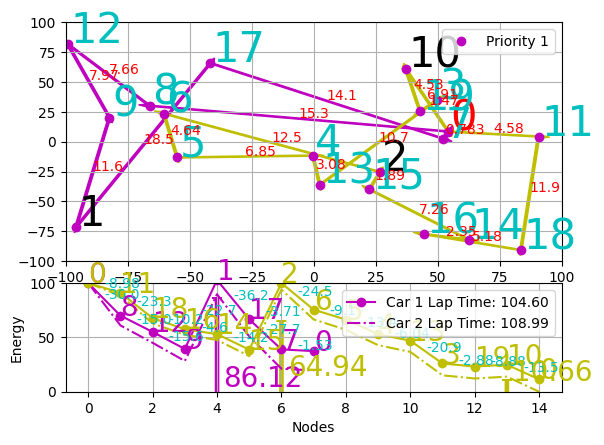

In [5]:
EnergyAlpha = norm.ppf(SolutionProbabilityEnergyReliability)
col_vec = ['m','y','b','r','g','c','k']
plt.figure()
plt.subplot(3,1,(1,2))
for i in range(MaxPriority):
    PriorIndx_i = np.where(NominalPlan.NodesPriorities[:,0] == i+1)
    plt.plot(NodesPosition[PriorIndx_i,0].T,NodesPosition[PriorIndx_i,1].T,'o',linewidth=10, color=col_vec[i])
plt.grid('on')
plt.xlim((Xmin,Xmax))
plt.ylim((Ymin,Ymax))
plt.legend(['Priority 1','Priority 2','Priority 3'])
if N<=10:
    for i in range(N):
        for j in range(i+1,N):
            plt.arrow(0.5*(NodesPosition[i,0]+NodesPosition[j,0]),0.5*(NodesPosition[i,1]+NodesPosition[j,1]),0.5*(NodesPosition[j,0]-NodesPosition[i,0]),0.5*(NodesPosition[j,1]-NodesPosition[i,1]), width= 0.01)
            plt.arrow(0.5*(NodesPosition[i,0]+NodesPosition[j,0]),0.5*(NodesPosition[i,1]+NodesPosition[j,1]),-0.5*(NodesPosition[j,0]-NodesPosition[i,0]),-0.5*(NodesPosition[j,1]-NodesPosition[i,1]), width= 0.01)
for i in range(N):
    colr = 'r' if i==0 else 'c'
    colr = 'k' if i in NominalPlan.ChargingStations else colr
    plt.text(NodesPosition[i,0]+1,NodesPosition[i,1]+1,"{:}".format(i), color=colr,fontsize=30)
for m in range(NumberOfCars):
    colr = col_vec[m] if m < len(col_vec) else 'k'
    for i in range(len(NodesTrajectory)-1):
        j1 = NodesTrajectory[i,m]
        j2 = NodesTrajectory[i+1,m]
        if (ReturnToBase==True and j1 > 0) or (ReturnToBase==False and j2>0) or i==0:
            plt.arrow(NodesPosition[j1,0],NodesPosition[j1,1],NodesPosition[j2,0]-NodesPosition[j1,0],NodesPosition[j2,1]-NodesPosition[j1,1], width= 1, color=colr)
            plt.text(0.5*NodesPosition[j1,0]+0.5*NodesPosition[j2,0], 1+0.5*NodesPosition[j1,1]+0.5*NodesPosition[j2,1],"{:.3}".format(NominalPlan.NodesTimeOfTravel[j1,j2]), color='r', fontsize=10)
# plt.title(SolverType)
plt.subplot(3,1,3)
leg_str = []
for m in range(NumberOfCars):
    colr = col_vec[m] if m < len(col_vec) else 'k'
    indx = np.argwhere(NodesTrajectory[:,m] > 0)
    indx = indx[-1][0] if ReturnToBase==False else indx[-1][0]+2
    plt.plot(Energy[0:indx,m],'o-',color=colr)
    # plt.plot(Energy[0:indx,m]+EnergyAlpha*EnergySigma[0:indx,m],'-.',color=colr)
    plt.plot(Energy[0:indx,m]-EnergyAlpha*EnergySigma[0:indx,m],'-.',color=colr)
    leg_str.append('Car '+str(m+1)+' Lap Time: '+"{:.2f}".format(np.max(TimeVec[:,m])))
    for i in range(indx):
        plt.text(i,Energy[i,m]+0.1,"{:}".format(NodesTrajectory[i,m]), color=colr,fontsize=20)
    for i in range(0,indx-1):
        plt.text(i+0.5,0.5*Energy[i,m]+0.5*Energy[i+1,m]+0.1,"{:.3}".format(NominalPlan.NodesEnergyTravel[NodesTrajectory[i,m],NodesTrajectory[i+1,m]]), color='c',fontsize=10)
plt.grid('on')
plt.ylim((0,PltParams.BatteryCapacity))
plt.legend(leg_str)
plt.ylabel('Energy')
# a_strings = ["%3.i" % BestPlan.NodesTrajectory[x,:] for x in range(N)]
# plt.xticks(ticks=np.arange(len(BestPlan.NodesTrajectory)),labels=a_strings)
for i in range(NumberOfChargeStations):
    j = NominalPlan.ChargingStations[i]
    indx = np.where(BestPlan.NodesTrajectory == j)
    if ChargingTime[int(j)] > 0:
        colr = col_vec[indx[1][0]] if m < len(col_vec) else 'k'
        if PltParams.RechargeModel == 'ConstantRate':
            Engery_i = ChargingTime[int(j)]*NominalPlan.StationRechargePower
        else:
            Engery_i = a1 + (Energy[indx[0][0],indx[1][0]]-a1)*np.exp(-a2*ChargingTime[int(j)])
        plt.arrow(indx[0][0],0,0,max(Engery_i,1.0), color=colr, width= 0.1)
        plt.text(indx[0][0]+0.2,5+i*5,"{:.2f}".format(Engery_i), color=colr,fontsize=20)
plt.xlabel('Nodes')
# plt.savefig(SolverType+'.png')

Car 1 90.0% Lap Time: 112.17, 95% Lap Time: 114.22
Car 1 Has a 0.00% chance of running out of energy
Car 2 90.0% Lap Time: 113.87, 95% Lap Time: 115.25
Car 2 Has a 0.11% chance of running out of energy


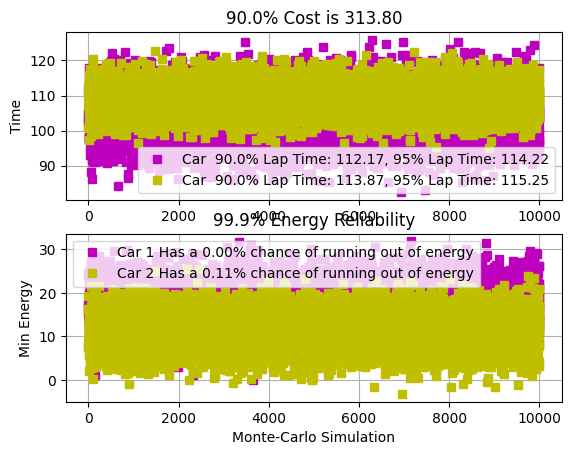

In [6]:
# Run Monte-Carlo Simulation for solution:
Nmc = 10000
FinalTime = np.zeros((Nmc,NumberOfCars))
MinEnergyLevel = np.zeros((Nmc,NumberOfCars))
for n in range(Nmc):
    TimeVec = np.zeros((NumberOfCars,1))
    for m in range(NumberOfCars):
        EnergyVec = np.zeros((N+1,1)) + InitialChargeStage
        for i in range(NodesTrajectory.shape[0]):
            TimeVec[m] += NominalPlan.NodesTimeOfTravel[NodesTrajectory[i,m],NodesTrajectory[i+1,m]] + ChargingTime[NodesTrajectory[i,m]] + np.random.normal(0,1)*NominalPlan.TravelSigma[NodesTrajectory[i,m],NodesTrajectory[i+1,m]]
            EnergyVec[i+1] = EnergyVec[i] + NominalPlan.NodesEnergyTravel[NodesTrajectory[i,m],NodesTrajectory[i+1,m]] + ChargingTime[NodesTrajectory[i,m]]*NominalPlan.StationRechargePower + np.random.normal(0,1)*NominalPlan.NodesEnergyTravelSigma[NodesTrajectory[i,m],NodesTrajectory[i+1,m]]
            EnergyVec[i+1] = min(EnergyVec[i+1],PltParams.BatteryCapacity)
            if i>0 and NodesTrajectory[i+1,m] == 0:
                break
        MinEnergyLevel[n,m] = np.min(EnergyVec)
    FinalTime[n,:] = TimeVec[:,0]

leg_str1 = []
leg_str2 = []
for m in range(NumberOfCars):
    sorted = np.sort(FinalTime[:,m])
    indx = int(SolutionProbabilityTimeReliability*Nmc)
    print('Car '+str(m+1)+' '+str(SolutionProbabilityTimeReliability*100)+'% Lap Time: '+"{:.2f}".format(sorted[indx])+', '+str(95)+'% Lap Time: '+"{:.2f}".format(sorted[int(0.95*Nmc)]))
    print('Car '+str(m+1)+' Has a '+"{:.2f}".format(100*np.sum(MinEnergyLevel[:,m]<0)/Nmc)+'% chance of running out of energy')
    leg_str1.append('Car '+' '+str(SolutionProbabilityTimeReliability*100)+'% Lap Time: '+"{:.2f}".format(sorted[indx])+', '+str(95)+'% Lap Time: '+"{:.2f}".format(sorted[int(0.95*Nmc)]))
    leg_str2.append('Car '+str(m+1)+' Has a '+"{:.2f}".format(100*np.sum(MinEnergyLevel[:,m]<0)/Nmc)+'% chance of running out of energy')
plt.figure()
plt.subplot(2,1,1)
for m in range(NumberOfCars):
    colr = col_vec[m] if m < len(col_vec) else 'k'
    plt.plot(FinalTime[:,m],'s',color=colr)
plt.legend(leg_str1)
plt.grid('on')
plt.ylabel('Time')
plt.title(str(SolutionProbabilityTimeReliability*100)+'% Cost is '+"{:.2f}".format(Cost))
plt.subplot(2,1,2)
for m in range(NumberOfCars):
    colr = col_vec[m] if m < len(col_vec) else 'k'
    plt.plot(MinEnergyLevel[:,m],'s',color=colr)
plt.grid('on')
plt.ylabel('Min Energy')
plt.xlabel('Monte-Carlo Simulation')
plt.title(str(SolutionProbabilityEnergyReliability*100)+'% Energy Reliability')
plt.legend(leg_str2)
plt.show()